In [1]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import gc
from concurrent.futures import ThreadPoolExecutor

In [2]:
def run_leiden(adata, resolution, key_added):
    adata_clustering = sc.tl.leiden(adata, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata_subset, tasks):
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = [executor.submit(run_leiden, adata_subset, resolution, key_added) for resolution, key_added in tasks]
        results = [future.result() for future in futures]

    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata_subset.obs[key_added] = result[key_added]

    return adata_subset

In [2]:
adata=sc.read_h5ad('adata_processed.h5ad')

In [3]:
B_cell_population=["7","12","26","27"]

In [4]:
adata_subset=adata[adata.obs['leiden'].isin(B_cell_population)]

In [5]:
del adata 
gc.collect()

12

In [6]:
adata_subset=adata_subset.raw.to_adata()

In [7]:
adata_subset.write_h5ad('B/Bcells_raw.h5ad')

In [3]:
adata_subset=sc.read_h5ad('B/Bcells_raw.h5ad')

In [4]:
adata_subset.raw= adata_subset

In [5]:
sc.pp.normalize_total(adata_subset, target_sum=1e4)

In [6]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [7]:
sc.pp.scale(adata_subset)

In [8]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [9]:
sce.pp.harmony_integrate(adata_subset, 'cohort.cohortGuid',max_iter_harmony = 30)

2023-11-04 21:25:17,983 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-04 21:30:59,186 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-04 21:31:00,935 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2023-11-04 21:35:48,719 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2023-11-04 21:41:14,912 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2023-11-04 21:44:56,728 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [10]:
sc.pp.neighbors(adata_subset, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata_subset)

In [11]:
tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata_subset = run_leiden_parallel(adata_subset, tasks)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [12]:
adata_subset.write_h5ad('B/Bcells_processed.h5ad')

In [13]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1', method='wilcoxon')
df_resolution_1=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_1.to_csv('B/B_res1.csv')

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1.5', method='wilcoxon')
df_resolution_1_5=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_1_5.to_csv('B/B_res1.5.csv')

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_2', method='wilcoxon')
df_resolution_2=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_2.to_csv('B/B_res2.csv')


/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [2]:
adata_subset=sc.read_h5ad('B/Bcells_processed.h5ad')

In [3]:
sc.tl.umap(adata_subset,min_dist=0.05)

In [9]:
adata_subset.write_h5ad('B/Bcells_processed_20231107.h5ad')

<Axes: title={'center': 'predicted.celltype.l2.5'}, xlabel='UMAP1', ylabel='UMAP2'>

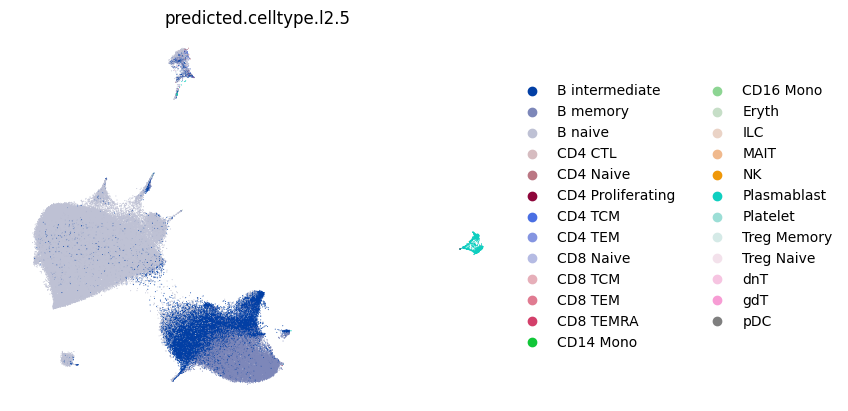

In [4]:
sc.pl.umap(adata_subset, color=['predicted.celltype.l2.5'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'predicted_labels_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

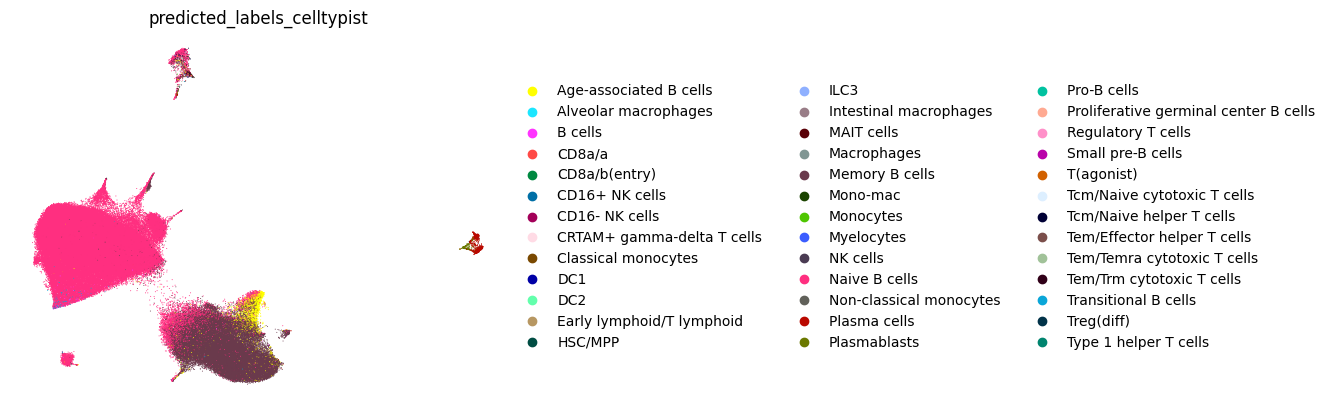

In [5]:
sc.pl.umap(adata_subset, color=['predicted_labels_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'majority_voting_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

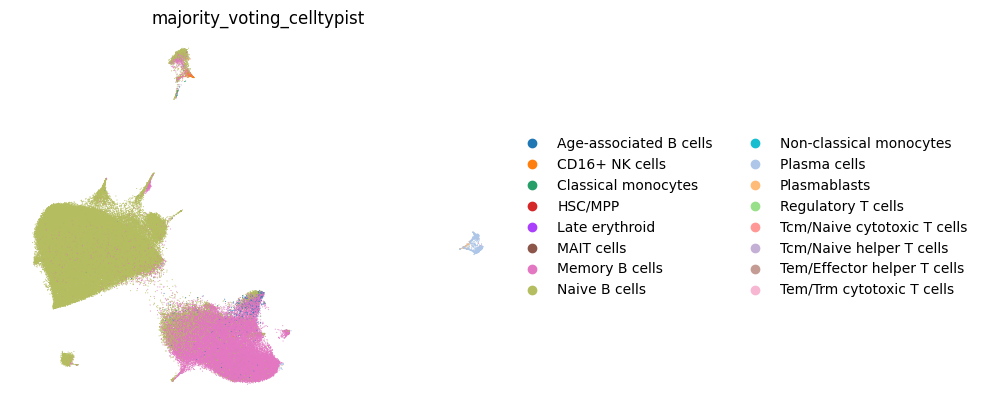

In [6]:
sc.pl.umap(adata_subset, color=['majority_voting_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

[<Axes: title={'center': 'leiden_resolution_1'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden_resolution_1.5'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden_resolution_2'}, xlabel='UMAP1', ylabel='UMAP2'>]

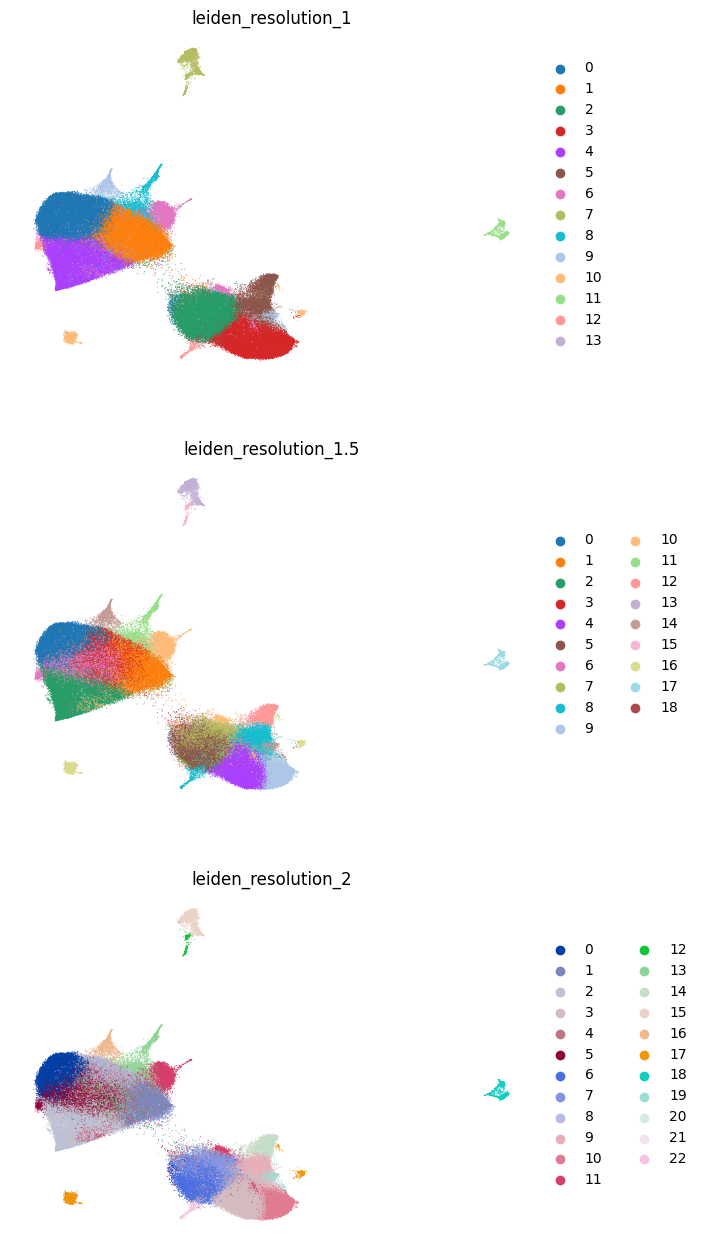

In [7]:
sc.pl.umap(adata_subset, color=['leiden_resolution_1','leiden_resolution_1.5','leiden_resolution_2'], 
           size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'CMV.IgG.Serology.Result.Interpretation'}, xlabel='UMAP1', ylabel='UMAP2'>

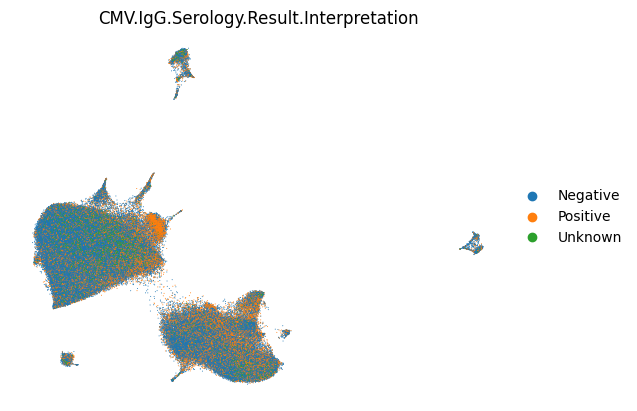

In [8]:
sc.pl.umap(adata_subset, color=['CMV.IgG.Serology.Result.Interpretation'], size=2,show=False,ncols=1 ,frameon=False)

In [35]:
df=pd.read_csv('B/B_res2.csv')

In [36]:
df=df.groupby('group').head(20).reset_index(drop=True)

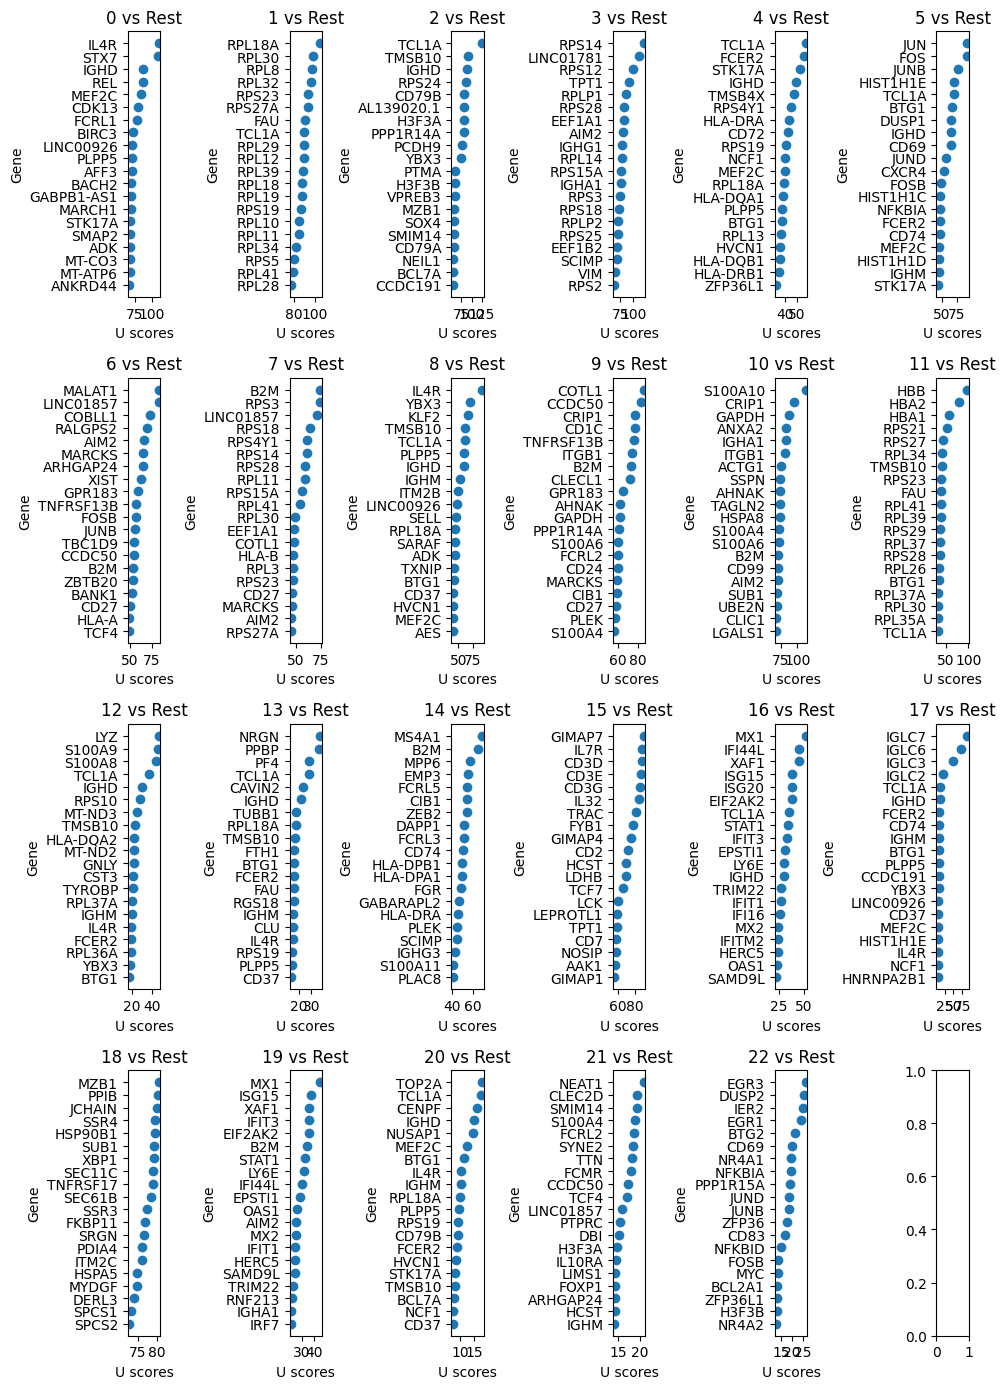

In [37]:
import matplotlib.pyplot as plt

groups = df.groupby('group')

fig, axs = plt.subplots(4, 6, figsize=(10, 14), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot
for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('U scores')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()
plt.savefig('scatter_plot.png')